Importing Initial Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from PIL import Image

Manage Directories

In [2]:
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR/ "raw"
TRAIN_DIR = RAW_DIR/ "train"
TEST_DIR = RAW_DIR/ "test"

print(f"Base directory: {BASE_DIR}")
print(f"Train Images: {TRAIN_DIR}")
print(f"Test Images: {TEST_DIR}")

Base directory: C:\Users\PC\Desktop\Data Science Project\Dog Breed
Train Images: C:\Users\PC\Desktop\Data Science Project\Dog Breed\data\raw\train
Test Images: C:\Users\PC\Desktop\Data Science Project\Dog Breed\data\raw\test


In [3]:
print(f"Train images:  {len(list(TRAIN_DIR.glob('*.jpg')))} files")
print(f"Test images:   {len(list(TEST_DIR.glob('*.jpg')))} files")

Train images:  10222 files
Test images:   10357 files


In [4]:
for p in [TRAIN_DIR, TEST_DIR]:
    if not p.exists():
        raise FileNotFoundError(f"Missing folder: {p}")
print("All required folders found.")

All required folders found.


Import and Check the dataset

In [5]:
labels_path = RAW_DIR/ "labels.csv"
labels_df = pd.read_csv(labels_path)

In [6]:
labels_df.shape

(10222, 2)

In [7]:
labels_df.columns

Index(['id', 'breed'], dtype='object')

In [8]:
labels_df.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


In [9]:
breeds_all = labels_df["breed"]
breed_counts = breeds_all.value_counts()
breed_counts.head(5)

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [10]:
print(f"Total unique breed: {breed_counts.shape[0]}")

Total unique breed: 120


In [11]:
print(f"Total training images: {len(labels_df)}")

Total training images: 10222


In [12]:
print("Top 5 most frequent breeds:\n", breed_counts.head(5))

Top 5 most frequent breeds:
 breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64


In [13]:
print("Bottom 5 least frequent breeds:\n", breed_counts.tail(5))

Bottom 5 least frequent breeds:
 breed
golden_retriever     67
komondor             67
brabancon_griffon    67
eskimo_dog           66
briard               66
Name: count, dtype: int64


In [14]:
print("Average images per breed:", breed_counts.mean())
print("Max images in a breed:", breed_counts.max())
print("Min images in a breed:", breed_counts.min())

Average images per breed: 85.18333333333334
Max images in a breed: 126
Min images in a breed: 66


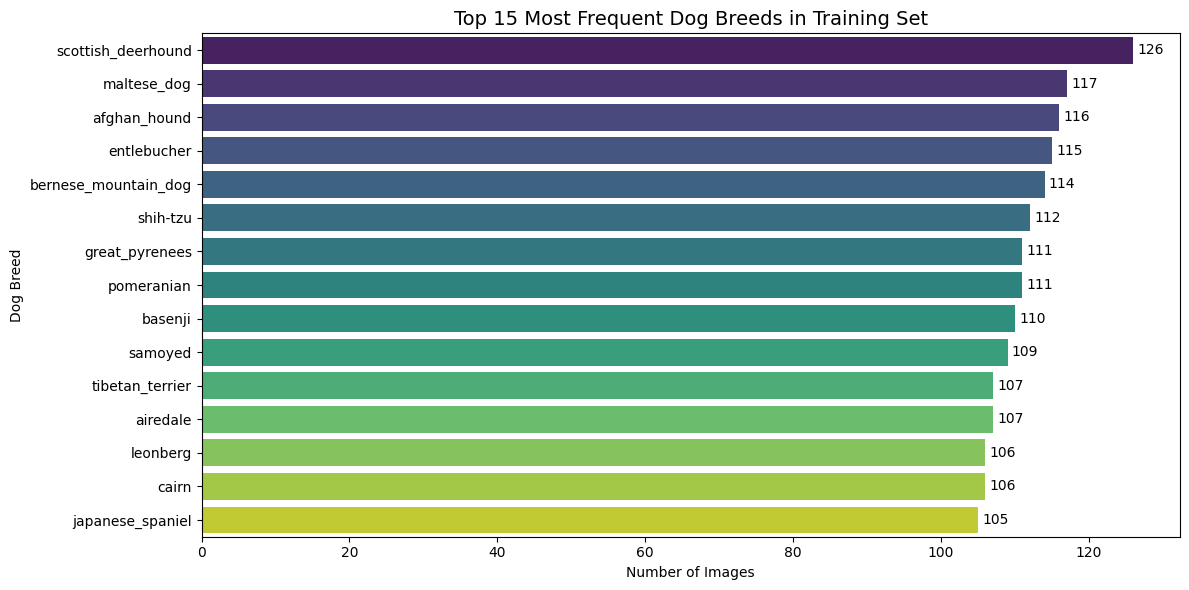

In [15]:
plt.figure(figsize=(12,6))
ax = sns.barplot(x=breed_counts.head(15).values,
            y=breed_counts.head(15).index,
            hue=breed_counts.head(15).index,
            palette="viridis")
plt.title("Top 15 Most Frequent Dog Breeds in Training Set", fontsize=14)
plt.xlabel("Number of Images")
plt.ylabel("Dog Breed")

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10, color='black')

plt.tight_layout()
plt.show()

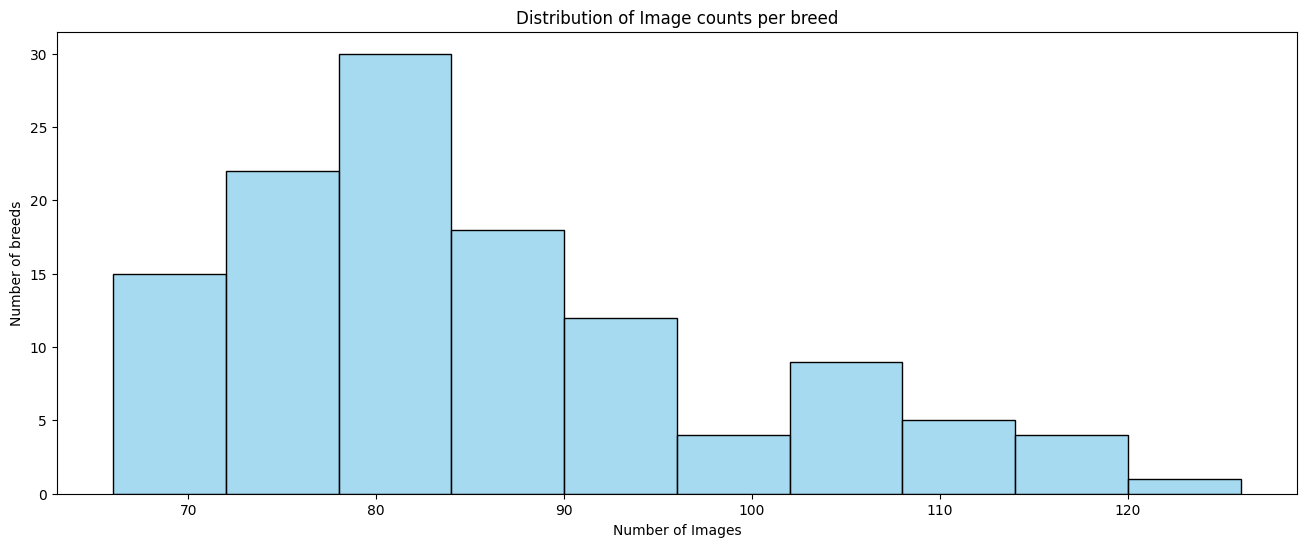

In [16]:
plt.figure(figsize=(16,6))
sns.histplot(breed_counts, bins=10, color="skyblue")
plt.title("Distribution of Image counts per breed")
plt.xlabel("Number of Images")
plt.ylabel("Number of breeds")
plt.show()

Model Training

Loading Data and Config

In [17]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cpu


In [19]:
# Dfine image transormation (resize + normalize the data)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], #ImageNet Mean
        std=[0.229, 0.224, 0.225], #ImageNet std
    )
])

In [20]:
breeds = sorted(labels_df['breed'].unique())
breed_to_idx = {b:i for i,b in enumerate(breeds)}
idx_to_breed = {i:b for b,i in breed_to_idx.items()}

In [21]:
class DogBreedTrainDataset(Dataset):
    def __init__(self, images_dir, labels_df, transform=None):
        self.images_dir = Path(images_dir)
        self.transform = transform
        # Keep only rows where the image file exists
        self.items = []
        for _id, breed in labels_df[['id','breed']].itertuples(index=False):
            img_path = self.images_dir / f"{_id}.jpg"
            if img_path.exists():
                self.items.append((img_path, breed_to_idx[breed]))
        if not self.items:
            raise FileNotFoundError(f"No images found in {self.images_dir}")
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        img_path, y = self.items[idx]
        img = Image.open(img_path).convert("RGB")
        if transform is not None:
            img = transform(img)
        return img, y

In [22]:
class DogBreedTestDataset(Dataset):
    """Unlabeled test set: returns (image_tensor, image_id_str)."""
    def __init__(self, images_dir, transform=None):
        self.images_dir = Path(images_dir)
        self.transform = transform
        self.items = sorted([p for p in self.images_dir.glob("*.jpg")])
        if not self.items:
            raise FileNotFoundError(f"No images found in {self.images_dir}")
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        img_path = self.items[idx]
        img = Image.open(img_path).convert("RGB")
        if transform is not None:
            img = transform(img)
        img_id = img_path.stem  # filename without .jpg
        return img, img_id

In [23]:
# Load Training and Test datasets
train_dataset = DogBreedTrainDataset(TRAIN_DIR, labels_df, transform=transform)
test_dataset  = DogBreedTestDataset(TEST_DIR, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Classes detected: {len(breeds)}")

Training images: 10222
Test images: 10357
Classes detected: 120


In [24]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

full_train_dataset = DogBreedTrainDataset(TRAIN_DIR, labels_df, transform=transform)

y_all = [y for _, y in full_train_dataset.items]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
train_idx, val_idx = next(sss.split(range(len(y_all)), y_all))

train_subset = Subset(full_train_dataset, train_idx)
val_subset   = Subset(full_train_dataset, val_idx)

pin = (device.type == "cuda")
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True,  num_workers=0, pin_memory=pin)
val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False, num_workers=0, pin_memory=pin)

print("Train/Val sizes:", len(train_subset), len(val_subset))

Train/Val sizes: 9199 1023


Load the pre-trained ResNet50

In [25]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

In [26]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(breeds))

model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Training Setup

In [27]:
import time
from typing import Dict
import torch.nn.functional as F

In [28]:
# Loss & optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [29]:
# Accuracy helper

def accuracy_from_logits(logits, targets):
    preds = torch.argmax(logits, dim=1)
    return (preds == targets).float().mean().item()


In [30]:
# One epoch train/ eval loops
from tqdm.auto import tqdm

def run_one_epoch(dataloader, model, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, total_acc, total_samples = 0.0, 0.0, 0
    t0 = time.time()

    loop = tqdm(dataloader, leave=False)  # progress bar
    for images, targets in loop:
        images, targets = images.to(device), targets.to(device)

        with torch.set_grad_enabled(is_train):
            logits = model(images)
            loss = criterion(logits, targets)
            acc = (logits.argmax(dim=1) == targets).float().mean().item()

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        bs = targets.size(0)
        total_loss += loss.item() * bs
        total_acc  += acc * bs
        total_samples += bs

        loop.set_description("train" if is_train else "valid")
        loop.set_postfix(loss=f"{loss.item():.4f}", acc=f"{acc:.4f}")

    avg_loss = total_loss / total_samples
    avg_acc  = total_acc  / total_samples
    return {"loss": avg_loss, "acc": avg_acc, "secs": time.time() - t0}


C:\Users\PC\Desktop\Data Science Project\Dog Breed\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train for N epochs, evaluate on test, save the best model

In [31]:
# config
from datetime import datetime

EPOCHS = 1 # can increase
best_val_acc = 0.0
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = Path("models") / f"run_{timestamp}"
save_path.mkdir(parents=True, exist_ok=True)
model_ckpt = save_path / "resnet50_dogbreed.pth"

In [33]:
for epoch in range(1, EPOCHS + 1):
    train_metrics = run_one_epoch(train_loader, model, optimizer=optimizer)
    val_metrics   = run_one_epoch(val_loader,   model, optimizer=None)
    scheduler.step()

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_metrics['loss']:.4f}  train_acc={train_metrics['acc']:.4f} | "
        f"val_loss={val_metrics['loss']:.4f}    val_acc={val_metrics['acc']:.4f} | "
        f"{int(train_metrics['secs'])}s train, {int(val_metrics['secs'])}s val"
    )

    if val_metrics["acc"] > best_val_acc:
        best_val_acc = val_metrics["acc"]
        torch.save({
            "model_state": model.state_dict(),
            "classes": breeds,
            "arch": "resnet50",
        }, model_ckpt)
        print(f"Saved new best model to {model_ckpt} (val_acc={best_val_acc:.4f})")

print(f"\nTraining complete. Best val_acc: {best_val_acc:.4f}")

Epoch 01 | train_loss=1.1132  train_acc=0.7549 | val_loss=0.6425    val_acc=0.8074 | 1130s train, 42s val
Saved new best model to models\run_20251109_201748\resnet50_dogbreed.pth (val_acc=0.8074)

Training complete. Best val_acc: 0.8074


Detailed test report (precision/recall/F1)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(targets.numpy().tolist())

labels_present = sorted(set(y_true))
target_names_present = [breeds[i] for i in labels_present]

print(classification_report(
    y_true, y_pred,
    labels=labels_present,
    target_names=target_names_present,
    zero_division=0
))


                                precision    recall  f1-score   support

                 affenpinscher       1.00      0.88      0.93         8
                  afghan_hound       1.00      1.00      1.00        12
           african_hunting_dog       1.00      1.00      1.00         9
                      airedale       0.79      1.00      0.88        11
american_staffordshire_terrier       0.86      0.86      0.86         7
                   appenzeller       0.80      0.50      0.62         8
            australian_terrier       0.83      0.50      0.62        10
                       basenji       1.00      0.91      0.95        11
                        basset       1.00      0.75      0.86         8
                        beagle       0.59      0.91      0.71        11
            bedlington_terrier       1.00      1.00      1.00         9
          bernese_mountain_dog       1.00      1.00      1.00        11
       black-and-tan_coonhound       0.75      0.75      0.75  

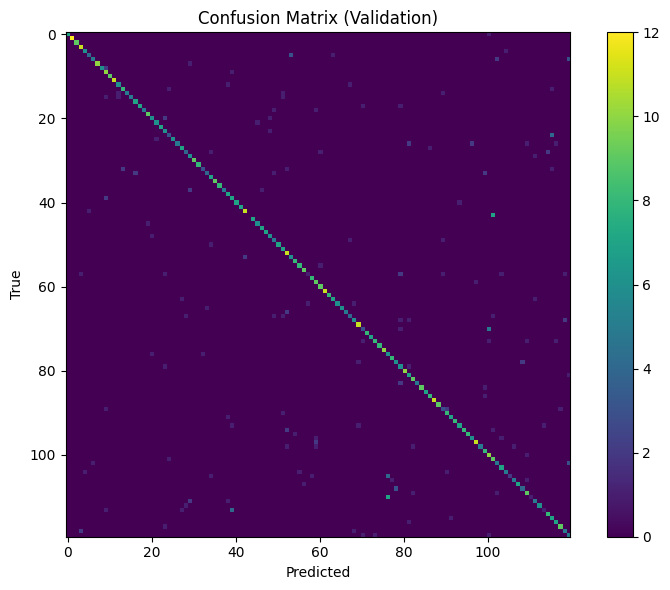

In [35]:
cm = confusion_matrix(y_true, y_pred, labels=labels_present)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Validation)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
plt.tight_layout()
plt.show()


Feature extraction + 2D/3D visualization (PCA & t-SNE)

In [36]:
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch.nn as nn
from torch.utils.data import Subset, DataLoader

In [37]:
# Feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
            backbone.avgpool,  # -> [B, 2048, 1, 1]
        )
    def forward(self, x):
        x = self.backbone(x)
        return torch.flatten(x, 1)  # -> [B, 2048]

feature_net = FeatureExtractor(model).to(device)
feature_net.eval()

FeatureExtractor(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [38]:
val_dataset = val_loader.dataset

In [39]:
MAX_SAMPLES = 1200
indices = list(range(len(val_dataset)))
random.seed(42); random.shuffle(indices)
indices = indices[:MAX_SAMPLES]

In [40]:
viz_subset = Subset(val_dataset, indices)
viz_loader = DataLoader(viz_subset, batch_size=64, shuffle=False, num_workers=0)

features = []
labels   = []

In [41]:
with torch.no_grad():
    for imgs, lbls in viz_loader:
        imgs = imgs.to(device)
        f = feature_net(imgs)
        features.append(f.cpu())
        labels.extend(lbls.numpy())

features = torch.cat(features, dim=0).numpy()
labels   = np.array(labels)
class_names = breeds

In [42]:
print("Feature matrix:", features.shape, "| Labels:", labels.shape)

Feature matrix: (1023, 2048) | Labels: (1023,)


PCA to 2D

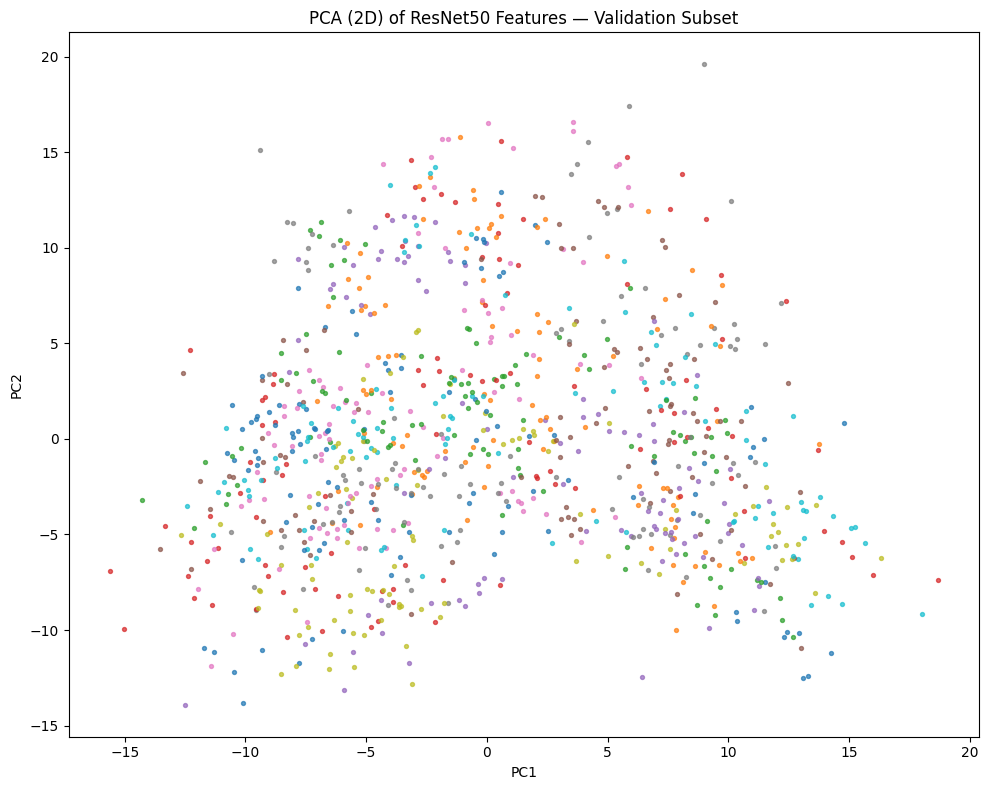

In [46]:
pca_2d = PCA(n_components=2, random_state=42).fit_transform(features)
plt.figure(figsize=(10, 8))
for cls_idx in np.unique(labels):
    m = labels == cls_idx
    plt.scatter(pca_2d[m, 0], pca_2d[m, 1], s=8, alpha=0.7, label=class_names[cls_idx])
plt.title("PCA (2D) of ResNet50 Features — Validation Subset")
plt.xlabel("PC1"); plt.ylabel("PC2")
#plt.legend(markerscale=3, fontsize=7, ncol=2, frameon=False)
plt.tight_layout()
plt.show()

t-SNE to 2D

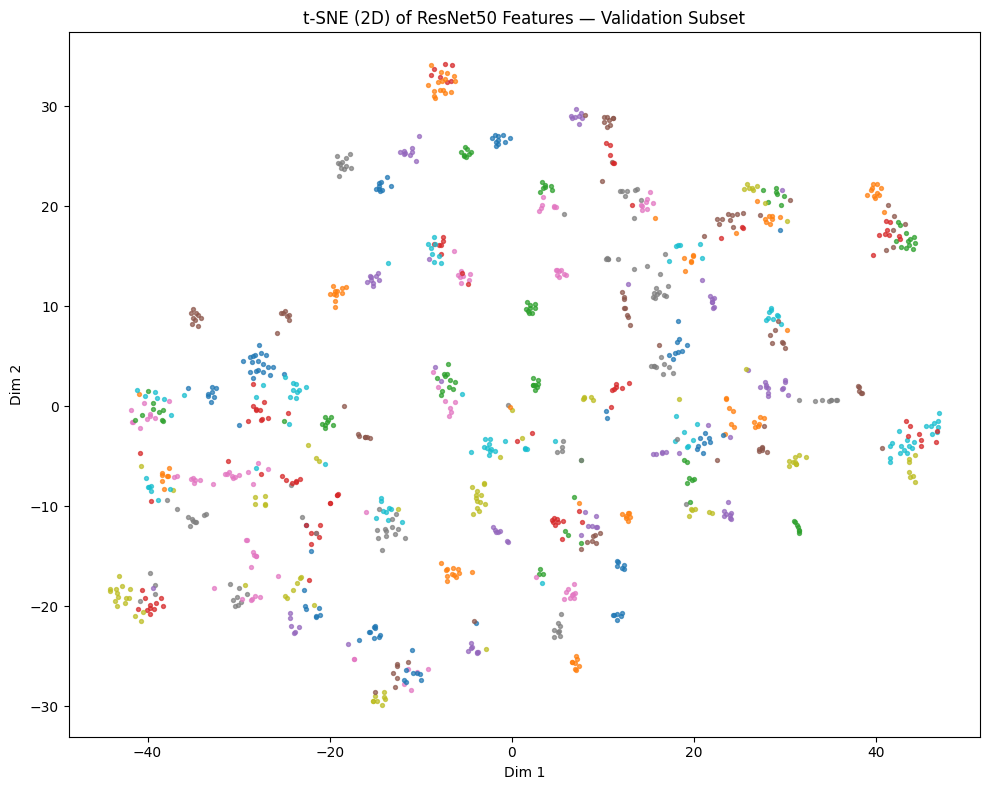

In [47]:
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42).fit_transform(features)
plt.figure(figsize=(10, 8))
for cls_idx in np.unique(labels):
    m = labels == cls_idx
    plt.scatter(tsne_2d[m, 0], tsne_2d[m, 1], s=8, alpha=0.7, label=class_names[cls_idx])
plt.title("t-SNE (2D) of ResNet50 Features — Validation Subset")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
#plt.legend(markerscale=3, fontsize=7, ncol=2, frameon=False)
plt.tight_layout()
plt.show()

3D PCA

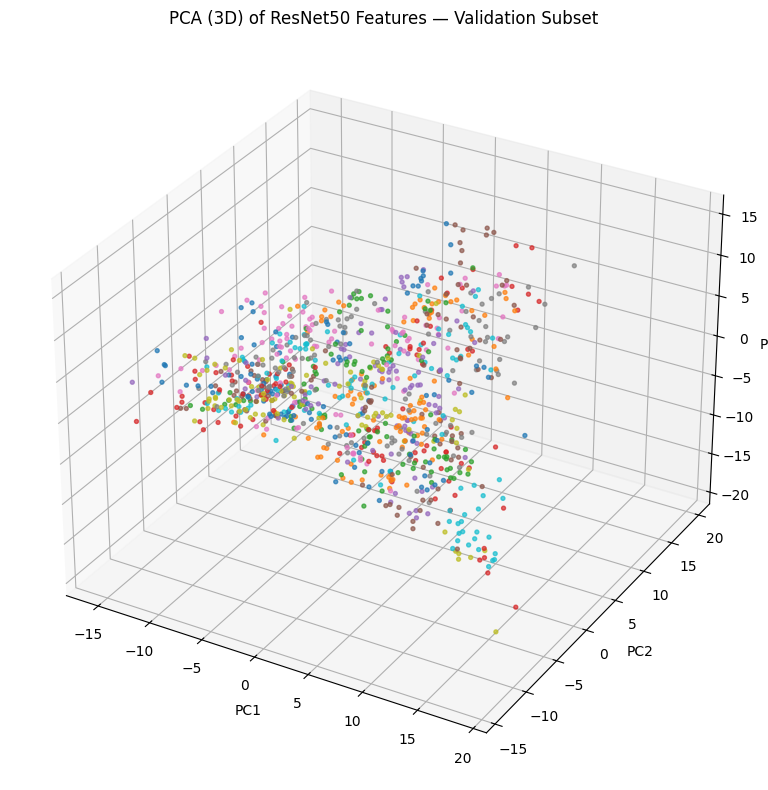

In [48]:
from mpl_toolkits.mplot3d import Axes3D  # noqa
pca_3d = PCA(n_components=3, random_state=42).fit_transform(features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for cls_idx in np.unique(labels):
    m = labels == cls_idx
    ax.scatter(pca_3d[m, 0], pca_3d[m, 1], pca_3d[m, 2], s=8, alpha=0.7, label=class_names[cls_idx])
ax.set_title("PCA (3D) of ResNet50 Features — Validation Subset")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
#ax.legend(markerscale=3, fontsize=7, ncol=2, frameon=False)
plt.tight_layout()
plt.show()

In [51]:
import json

app_assets = Path("app/assets")
app_assets.mkdir(parents=True, exist_ok=True)
with open(app_assets / "class_names.json", "w", encoding="utf-8") as f:
    json.dump(breeds, f, indent=2)
print("Saved app/assets/class_names.json")


Saved app/assets/class_names.json
